In [9]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [6]:
def show_image(img, title=""):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

    plt.axis('off')
    if title != "":
        plt.title(title)
    plt.show()

In [7]:
def __order_points(points) -> np.array:
    """Utility function - order coordinates tuple by position in by quadrant position.

    Args:
        points (np.array): Unordered array of points.

    Returns:
        ordered points: Ordered array of points.
    """
    # Convert the input points to a NumPy array
    points = np.array(points)

    # Initialize an array to store the ordered points
    ordered_points = np.zeros_like(points)

    # Calculate the centroid of the points
    centroid = np.mean(points, axis=0)

    # Calculate the angles between the centroid and each point
    angles = np.arctan2(points[:, 1] - centroid[1], points[:, 0] - centroid[0])

    # Sort the points based on angles
    ordered_indices = np.argsort(angles)
    ordered_points = points[ordered_indices]

    return ordered_points


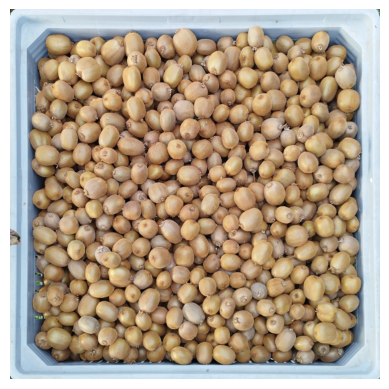

In [14]:
# image = cv2.imread("/home/ettore/Projects/siv-kiwi-recon/datasets/test/test_bin.jpg")

image = cv2.imread("/home/ettore/Projects/siv-kiwi-recon/dataset/storage/__original_imgs/raw-selected/IMG_20231028_170944.jpg")

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_color = (79, 0, 179)
upper_color = (128, 255, 255)

# Create a binary mask based on color segmentation
thresh = cv2.inRange(hsv, lower_color, upper_color)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
dilated = cv2.dilate(morph, kernel, iterations=2)

# Apply GaussianBlur to reduce noise
blurred = cv2.GaussianBlur(dilated, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, 100, 150)

# Combine color and edge masks - looks like it's adding noise
combined_mask = cv2.bitwise_or(dilated, edges)

# Find contours in the combined mask
contours, _ = cv2.findContours(
    combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Find the contour with the maximum area (assumed to be the bin)
max_contour = max(contours, key=cv2.contourArea)

epsilon = 0.02 * cv2.arcLength(max_contour, True)
approx_contour = cv2.approxPolyDP(max_contour, epsilon, True)

red_box_min_side = np.int32(
    np.abs(approx_contour[:, 0, 0] - approx_contour[:, 0, 1]).mean()
)

# Define the target points for perspective correction
target_points = np.array(
    [
        [red_box_min_side, red_box_min_side],
        [0, red_box_min_side],
        [red_box_min_side, 0],
        [0, 0],
    ],
    dtype=np.float32,
)

# Order the points
approx_ordered = __order_points(approx_contour.reshape(-1, 2)).reshape(-1, 1, 2)
target_points_ordered = __order_points(target_points).reshape(-1, 1, 2)

# Calculate the perspective transformation matrix
perspective_matrix = cv2.getPerspectiveTransform(
    approx_ordered.reshape(4, 2).astype(np.float32),
    target_points_ordered.reshape(4, 2),
)

dst = cv2.warpPerspective(
    image, perspective_matrix, (red_box_min_side, red_box_min_side)
)
show_image(dst)



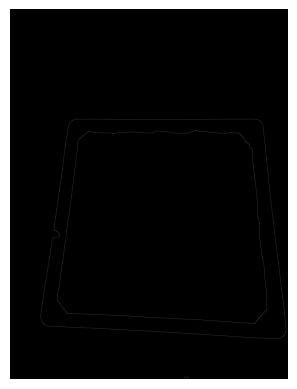

In [15]:
show_image(edges)

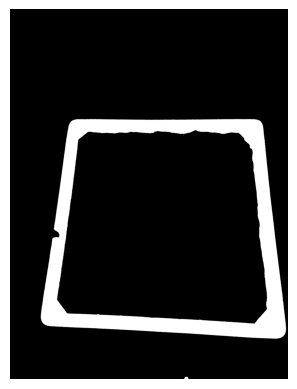

In [16]:
show_image(dilated)